In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy
import pymc
from pymc import *
import seaborn as sns
import pandas as pd
import plotly 
import pylab
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# data: the number of active domains each year.
data =  [[3712,3031,2318,1889,1667,1498,1357,1246,1163,1107,1055,996,935],
        [198,160,131,116,112,97,85,78,75,68,61,59,59],
        [230,178,144,111,100,85,77,74,70,66,61,59,57]]

In [3]:
#calculate actual number of cancellations each year
def cancelled(data):
    cancell = [None]
    for i in range(1, len(data)):
        cancell.append(data[i - 1] - data[i])
    return cancell

In [4]:
#calculate actual surviving probability
def actual_sv(data):
    actual_sv_count = [100]
    for i in range(1,len(data)):
        actual_sv_count.append(data[i]/data[0]*100)
    return actual_sv_count

In [5]:
#calculate actual retention rate
def actual_ret(data):
    actual_ret_count = [None]
    for i in range(1, len(data)):
        actual_ret_count.append(data[i]/data[i-1])
    return actual_ret_count

In [6]:
# calculate P(T=t), function (7) of the paper
def cal_P_T(alpha, beta, data):
    time_frame = len(data)
    @pymc.deterministic  # function decrators.
    def P_T(alpha=alpha, beta=beta, time_frame=time_frame):
        p = [None, alpha / (alpha + beta)]
        for t in range(2, time_frame):
            pt = (beta + t - 2) / (alpha + beta + t - 1) * p[t-1]
            p.append(pt)
        return p
    return P_T

In [7]:
#implement suvival function
def cal_sv_func(alpha, beta,cal_P_T,data):
    time_frame = len(data)
    @pymc.deterministic
    def sv_func(P_T = cal_P_T(alpha,beta,data), time_frame = time_frame):
        sv = [None, 1 - P_T[1]]
        for t in range(2, time_frame):
            sv.append(sv[t-1] - P_T[t])
        return sv
    return sv_func

In [8]:
#likelihood function 
def cal_ret_rate(alpha, beta, cal_P_T, cal_sv_func, data):
    @pymc.observed
    def ret_rate(P_T=cal_P_T(alpha,beta,data), sv_func=cal_sv_func(alpha,beta,cal_P_T,data),value=data):
        def logp(value,P_T, sv_func):
            active = data
            actual_cancelled = cancelled(data)
            part_1 = np.log(P_T[1:]) * actual_cancelled[1:]
            part_2 = np.log(sv_func[-1]) * active[-1]
            return sum(part_1) + part_2   
    return ret_rate
#cal_ret_rate(alpha, beta, cal_P_T,cal_sv_func,sample_data).logp

In [9]:
#function for model-based retention rate.
def cal_model_rt(alpha_hat, beta_hat, data):
    r_t_model = [None]
    for i in range(1,len(data)):
        r_t = (beta_hat+i-1)/(alpha_hat + beta_hat+i-1) #function (8) in paper
        r_t_model.append(r_t)
    return r_t_model       

In [10]:
#function for  model-based surviving probability.
def cal_model_sv(alpha_hat, beta_hat, data, cal_model_rt):
    sv_t_model = [100]
    for t in range(1,len(data)):
        sv_t = sv_t_model[t-1] * cal_model_rt[t]
        sv_t_model.append(sv_t)
    return sv_t_model

In [11]:
# estimate parameters for different data sets.
alpha_hat = defaultdict(list)
beta_hat = defaultdict(list)
for year in range(6, 9):
    for i in range(0, len(data)):
        sample_data = data[i][0:year+1]
        alpha = pymc.Uniform('alpha', 0.0001, 10, value=1)
        beta = pymc.Uniform('beta', 0.0001, 10, value=1)
        mcmc = pymc.MCMC([alpha, beta, cal_P_T(alpha, beta, sample_data),
                          cal_sv_func(alpha, beta, cal_P_T, sample_data),
                          cal_ret_rate(alpha, beta, cal_P_T, cal_sv_func,
                                       sample_data)])
        mcmc.sample(100000, 1000, 10)
        df_trace = pd.DataFrame({'alpha': alpha.trace(), 'beta': beta.trace()})
        alpha_hat[year].append(df_trace.median()[0])
        beta_hat[year].append(df_trace.median()[1])

 [-----------------100%-----------------] 100 of 100 complete in 0.1 sec

In [15]:
#calculate model-based numbers.
model_rt = defaultdict(list)
model_sv = defaultdict(list)

for i in range(0,len(data)):
    for year in alpha_hat:
        model_rt[year].append(cal_model_rt(alpha_hat[year][i], beta_hat[year][i],data[i]))
        model_sv[year].append(cal_model_sv(alpha_hat[year][i], beta_hat[year][i],data[i], model_rt[year][i]) )
    

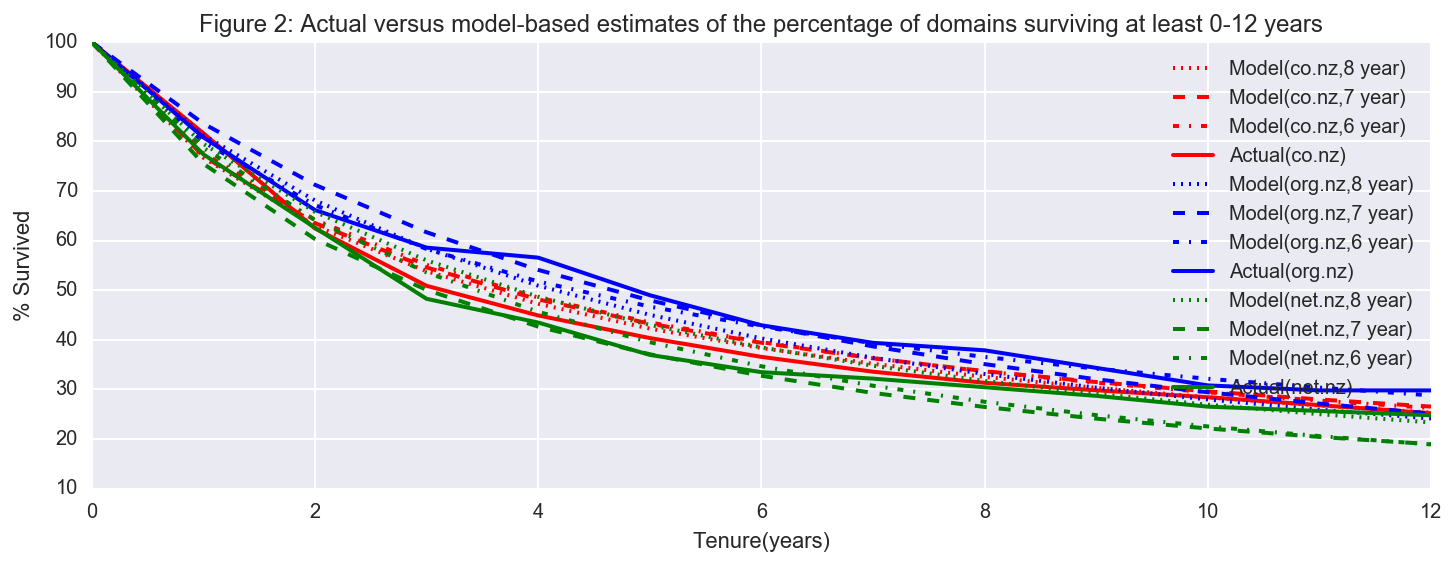

In [17]:
# plot for surviving probability.
fig, ax = plt.subplots(figsize=(12,4))
ax.set(title='Figure 2: Actual versus model-based estimates of the percentage of domains surviving at least 0-12 years', 
xlabel='Tenure(years)', ylabel='% Survived')

# for co.nz surviving percentage.
co_8 = model_sv[8][0]
df_co_8 = pd.DataFrame(co_8, columns = ['sv'] )
df_co_8.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle=':', color='r', label='Model(co.nz,8 year)')
co_7 = model_sv[7][0]
df_co_7 = pd.DataFrame(co_7, columns = ['sv'] )
df_co_7.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='--', color='r', label='Model(co.nz,7 year)')
co_6 = model_sv[6][0]
df_co_6 = pd.DataFrame(co_6, columns = ['sv'] )
df_co_6.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='-.', color='r', label='Model(co.nz,6 year)')
co_actual = actual_sv(data[0])

df_co_actual = pd.DataFrame(co_actual, columns = ['sv'] )
df_co_actual.ix[:,'sv'].plot(ax=ax, linewidth=2, color='r', label='Actual(co.nz)')


# for org.nz surviving percentage.
org_8 = model_sv[8][1]
df_org_8 = pd.DataFrame(org_8, columns = ['sv'] )
df_org_8.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle=':', color='b', label='Model(org.nz,8 year)')
org_7 = model_sv[7][1]
df_org_7 = pd.DataFrame(org_7, columns = ['sv'] )
df_org_7.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='--', color='b', label='Model(org.nz,7 year)')
org_6 = model_sv[6][1]
df_org_6 = pd.DataFrame(org_6, columns = ['sv'] )
df_org_6.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='-.', color='b', label='Model(org.nz,6 year)')
org_actual = actual_sv(data[1])
df_org_actual = pd.DataFrame(org_actual, columns = ['sv'] )
df_org_actual.ix[:,'sv'].plot(ax=ax, linewidth=2, color='b', label='Actual(org.nz)')

#for net.nz surviving percentage.
net_8 = model_sv[8][2]
df_net_8 = pd.DataFrame(net_8, columns = ['sv'] )
df_net_8.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle=':', color='g', label='Model(net.nz,8 year)')
net_7 = model_sv[7][2]
df_net_7 = pd.DataFrame(net_7, columns = ['sv'] )
df_net_7.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='--', color='g', label='Model(net.nz,7 year)')
net_6 = model_sv[6][2]
df_net_6 = pd.DataFrame(net_6, columns = ['sv'] )
df_net_6.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='-.', color='g', label='Model(net.nz,6 year)')
net_actual = actual_sv(data[2])
df_net_actual = pd.DataFrame(net_actual, columns = ['sv'] )
df_net_actual.ix[:,'sv'].plot(ax=ax, linewidth=2, color='g', label='Actual(net.nz)')



legend = ax.legend(loc='upper right');
legend.get_frame().set_facecolor('w')




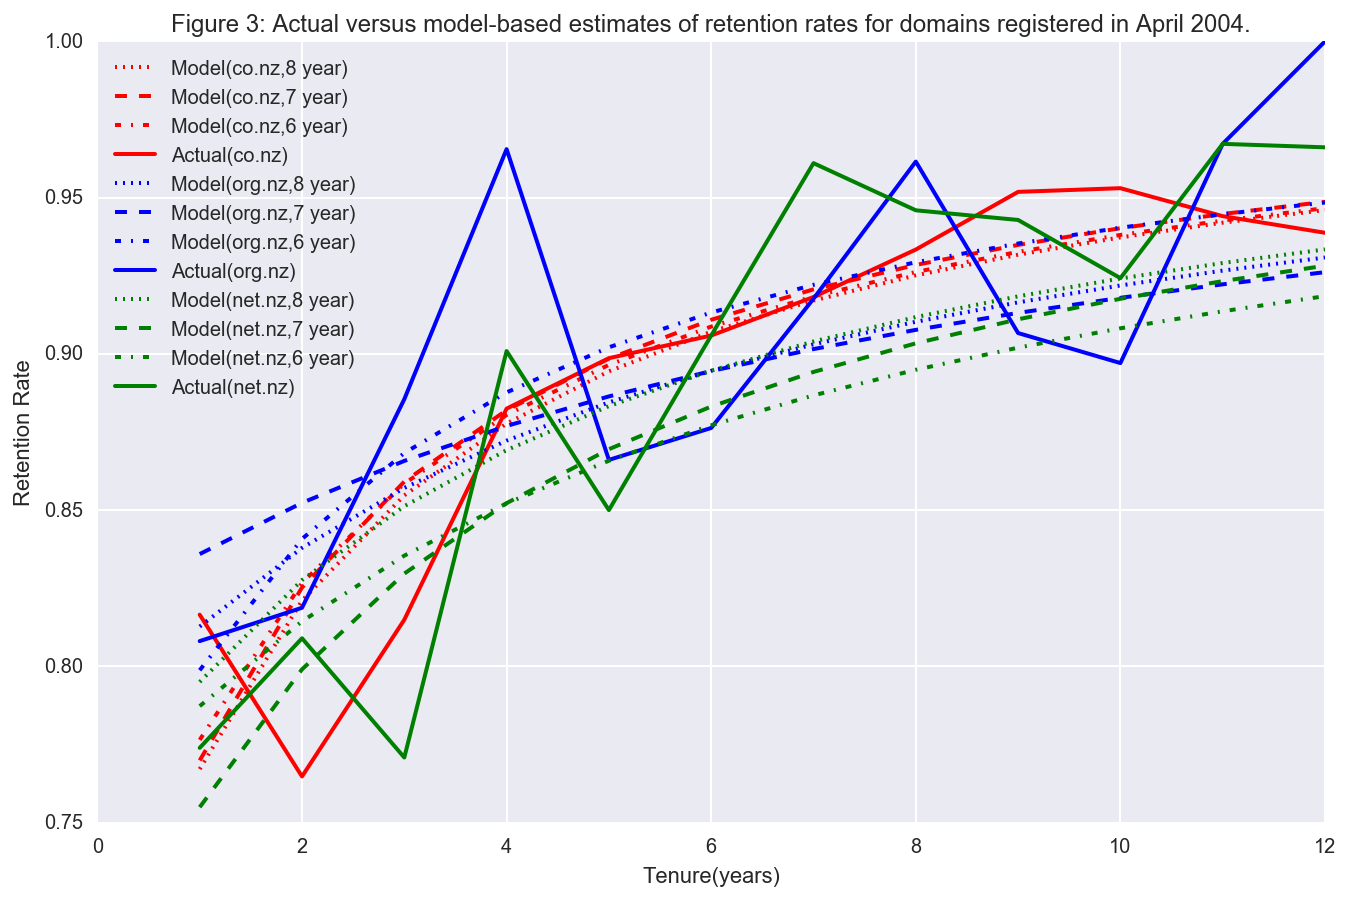

In [19]:
# plot for retention rate.
fig, ax = plt.subplots(figsize=(11,7))
ax.set(title= 'Figure 3: Actual versus model-based estimates of retention rates for domains registered in April 2004.', 
xlabel='Tenure(years)', ylabel='Retention Rate')

# for co.nz retention rate.
co_8 = model_rt[8][0]
df_co_8 = pd.DataFrame(co_8, columns = ['sv'] )
df_co_8.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle=':', color='r', label='Model(co.nz,8 year)')
co_7 = model_rt[7][0]
df_co_7 = pd.DataFrame(co_7, columns = ['sv'] )
df_co_7.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='--', color='r', label='Model(co.nz,7 year)')
co_6 = model_rt[6][0]
df_co_6 = pd.DataFrame(co_6, columns = ['sv'] )
df_co_6.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='-.', color='r', label='Model(co.nz,6 year)')
co_actual = actual_ret(data[0])
df_co_actual = pd.DataFrame(co_actual, columns = ['sv'] )
df_co_actual.ix[:,'sv'].plot(ax=ax, linewidth=2, color='r', label='Actual(co.nz)')

# for org.nz retentino rate.
org_8 = model_rt[8][1]
df_org_8 = pd.DataFrame(org_8, columns = ['sv'] )
df_org_8.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle=':', color='b', label='Model(org.nz,8 year)')
org_7 = model_rt[7][1]
df_org_7 = pd.DataFrame(org_7, columns = ['sv'] )
df_org_7.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='--', color='b', label='Model(org.nz,7 year)')
org_6 = model_rt[6][1]
df_org_6 = pd.DataFrame(org_6, columns = ['sv'] )
df_org_6.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='-.', color='b', label='Model(org.nz,6 year)')
org_actual = actual_ret(data[1])
df_org_actual = pd.DataFrame(org_actual, columns = ['sv'] )
df_org_actual.ix[:,'sv'].plot(ax=ax, linewidth=2, color='b', label='Actual(org.nz)')


#for net.nz surviving percentage.
net_8 = model_rt[8][2]
df_net_8 = pd.DataFrame(net_8, columns = ['sv'] )
df_net_8.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle=':', color='g', label='Model(net.nz,8 year)')
net_7 = model_rt[7][2]
df_net_7 = pd.DataFrame(net_7, columns = ['sv'] )
df_net_7.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='--', color='g', label='Model(net.nz,7 year)')
net_6 = model_rt[6][2]
df_net_6 = pd.DataFrame(net_6, columns = ['sv'] )
df_net_6.ix[:,'sv'].plot(ax=ax, linewidth=2,linestyle='-.', color='g', label='Model(net.nz,6 year)')
net_actual = actual_ret(data[2])
df_net_actual = pd.DataFrame(net_actual, columns = ['sv'] )
df_net_actual.ix[:,'sv'].plot(ax=ax, linewidth=2, color='g', label='Actual(net.nz)')

pylab.ylim([0.75,1])

legend = ax.legend(loc='best');
legend.get_frame().set_facecolor('w')

